In [9]:
from collections import defaultdict
from PIL import Image
import numpy as np
import os
import skimage.color as color
import PIL
from matplotlib import pyplot as plt

## Load List of Images

In [10]:
from utils.imgCap import load_images_list
from zipfile import ZipFile

# Extract Data
if not os.path.exists('./Flickr_Data.zip'):
    raise Exception('Dataset not found. Please read instructions above this cell and download dataset.')

if not os.path.exists('./Flickr_Data'):
    print("Extracting data ...")
    ZipFile('./Flickr_Data.zip', 'r').extractall('./')

#Files with names of corresponding images
train_image_list_path = './Flickr_Data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_image_list_path = './Flickr_Data/Flickr8k_text/Flickr_8k.testImages.txt'

train_image_list = load_images_list(train_image_list_path)
test_image_list = load_images_list(test_image_list_path)

print('Total train images:',len(train_image_list))
print('Total test images:', len(test_image_list))

Total train images: 6000
Total test images: 1000


## Method to Convert Image from RGB to LaB

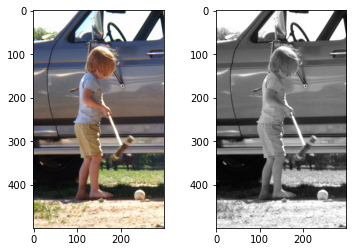

In [11]:
image = Image.open('./Flickr_Data/Flickr8k_Dataset/2903617548_d3e38d7f88.jpg', mode='r')
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(image)
f.add_subplot(1,2, 2)
lab_image = color.rgb2lab(np.asarray(image))
plt.imshow(lab_image[:,:,0],cmap="gray")
plt.show(block=True)

## Encode Image for Resnet Embedding

In [12]:
# Resize the original images to 299*299
# Then, convert them to LaB images
# "L" is the input for the later model and "aB" is the ground truth for model output

train_data = np.zeros([600, 299, 299, 3])
test_data = np.zeros([100, 299, 299, 3])

images_path = './Flickr_Data/Flickr8k_Dataset'
i = 0
for image_name in train_image_list:
        path = images_path + "/" + image_name
        image = Image.open(path, mode='r')
        image = image.resize((299,299))
        x = color.rgb2lab(np.asarray(image))
        x = x/255
        x = x.reshape((1,299,299,3))
        train_data[i,:,:,:] = x
        i += 1
        if i>=600:
            break

i = 0
for image_name in test_image_list:
        path = images_path + "/" + image_name
        image = Image.open(path, mode='r')
        image = image.resize((299,299))
        x = color.rgb2lab(np.asarray(image))
        x = x/255
        x = x.reshape((1,299,299,3))
        test_data[i,:,:,:] = x
        i += 1
        if i>=100:
            break

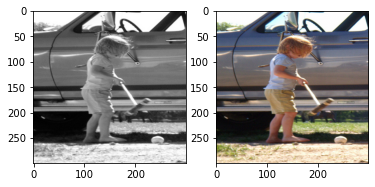

In [13]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(train_data[1,:,:,0],cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(color.lab2rgb(train_data[1]*255))
plt.show(block=True)

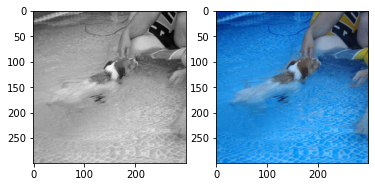

In [14]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(test_data[1,:,:,0],cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(color.lab2rgb(test_data[1]*255))
plt.show(block=True)

## Resnet Embedding and Stacking

In [15]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import Model
pre_trained_model = InceptionResNetV2(weights='imagenet')
feature_extractor = Model(inputs=pre_trained_model.input,outputs=pre_trained_model.layers[-2].output)

In [16]:
train_embeddings = np.zeros([600, 299, 299, 3],dtype='float32')
train_embeddings[:,:,:,0] = train_embeddings[:,:,:,1] = train_embeddings[:,:,:,2] = train_data[:,:,:,0]

test_embeddings = np.zeros([100, 299, 299, 3],dtype='float32')
test_embeddings[:,:,:,0] = test_embeddings[:,:,:,1] = test_embeddings[:,:,:,2] = test_data[:,:,:,0]

train_emb = feature_extractor.predict(train_embeddings)
test_emb = feature_extractor.predict(test_embeddings)

In [17]:
if not os.path.exists('./encoded_images'):
    os.mkdir('./encoded_images')
np.save('./encoded_images/train_emb.npy',train_emb)
np.save('./encoded_images/test_emb.npy',test_emb)

In [18]:
train_emb = np.load('./encoded_images/train_emb.npy')
test_emb = np.load('./encoded_images/test_emb.npy')
train_emb = train_emb.reshape([600,1,1,1536])
test_emb = test_emb.reshape([100,1,1,1536])

In [19]:
train_embeddings = np.zeros([600,28,28,1536],dtype='float32')
for i in range(600):
    for j in range(28):
        train_embeddings[i,j,j,:] = train_emb[i,0,0,:]
        
train_embeddings.shape

(600, 28, 28, 1536)

In [20]:
test_embeddings = np.zeros([100,28,28,1536],dtype='float32')
for i in range(100):
    for j in range(28):
        test_embeddings[i,j,j,:] = test_emb[i,0,0,:]
        
test_embeddings.shape

(100, 28, 28, 1536)

## prepare Data for Model

In [21]:
train_data = np.zeros([600, 224, 224, 3])
test_data = np.zeros([100, 224, 224, 3])

images_path = './Flickr_Data/Flickr8k_Dataset'
i = 0
for image_name in train_image_list:
        path = images_path + "/" + image_name
        image = Image.open(path, mode='r')
        image = image.resize((224,224))
        x = color.rgb2lab(np.asarray(image))
        x = x/255
        x = x.reshape((1,224,224,3))
        train_data[i,:,:,:] = x
        i += 1
        if i>=600:
            break

i = 0
for image_name in test_image_list:
        path = images_path + "/" + image_name
        image = Image.open(path, mode='r')
        image = image.resize((224,224))
        x = color.rgb2lab(np.asarray(image))
        x = x/255
        x = x.reshape((1,224,224,3))
        test_data[i,:,:,:] = x
        i += 1
        if i>=100:
            break

In [22]:
np.save('./encoded_images/train_data.npy',train_data)
np.save('./encoded_images/test_data.npy',test_data)

## Define Model

In [23]:
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Concatenate,UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Embedding, Add, Bidirectional, Concatenate, RepeatVector, GRU


start = Input(shape=(224,224,1))
encoder = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2,2))(start)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2,2))(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2,2))(encoder)
encoder = Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder)
encoder = Conv2D(512, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder)

feature_extractor = Input(shape=(28,28,1536))
fusion = Concatenate()([encoder,feature_extractor])
fusion = Conv2D(256, (1, 1), activation='relu', padding='same', strides=1)(fusion)

decoder = Conv2D(128, (3, 3), activation="relu", padding="same")(fusion)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3, 3), activation="relu", padding="same")(decoder)
decoder = Conv2D(64, (3, 3), activation="relu", padding="same")(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(32, (3, 3), activation="relu", padding="same")(decoder)
decoder = Conv2D(2, (3, 3), activation="tanh", padding="same")(decoder)
decoder = UpSampling2D((2, 2))(decoder)

deep_color = Model([start,feature_extractor],decoder)

deep_color.compile(optimizer='Adam',loss='mse',metrics=['accuracy'])

deep_color.summary()
#Train the neural network
#model.fit(x=X, y=Y, batch_size=1, epochs=3000)
#print(model.evaluate(X, Y, batch_size=1))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_420 (Conv2D)             (None, 112, 112, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_421 (Conv2D)             (None, 112, 112, 128 73856       conv2d_420[0][0]                 
__________________________________________________________________________________________________
conv2d_422 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_421[0][0]                 
____________________________________________________________________________________________

## Train Model

In [24]:
train_data = np.load('./encoded_images/train_data.npy')

In [25]:
train_input = train_data[:,:,:,0].reshape([600,224,224,1])
train_input.shape

(600, 224, 224, 1)

In [26]:
train_embeddings.shape

(600, 28, 28, 1536)

In [27]:
train_output = train_data[:,:,:,1:]
train_output.shape

(600, 224, 224, 2)

In [28]:
deep_color.fit([train_input,train_embeddings],train_output, epochs=20,batch_size=60)

Epoch 1/20
10/10 [==============================] - 6s 632ms/step - loss: 0.0042 - accuracy: 0.5852
Epoch 2/20
10/10 [==============================] - 17s 2s/step - loss: 0.0036 - accuracy: 0.6131
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.0035 - accuracy: 0.6152
Epoch 4/20
10/10 [==============================] - 21s 2s/step - loss: 0.0035 - accuracy: 0.6161
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 0.0035 - accuracy: 0.6164
Epoch 6/20
10/10 [==============================] - 20s 2s/step - loss: 0.0035 - accuracy: 0.6168
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.0035 - accuracy: 0.6169
Epoch 8/20
10/10 [==============================] - 21s 2s/step - loss: 0.0035 - accuracy: 0.6180
Epoch 9/20
10/10 [==============================] - 21s 2s/step - loss: 0.0034 - accuracy: 0.6204
Epoch 10/20
10/10 [==============================] - 21s 2s/step - loss: 0.0034 - accuracy: 0.6217
Epoch 11/20
10/10